# Aplying the recomendator system

This notebook is a part of the project Library recomender system. To generet the datases used in this notebook, we have used spiders to colect biblographis registers and users trasactions over  many  library sites.
The bibliograthic registers have been already unificated and associated with a unique identifier class "codObra";


Ever time that the spider find a  new transactions, its necessary to convert the local id to the "codObra" id. The last notebook is about row to joing the recomender with a unified register id.  
This notebook shows how to use  the spark library to buld a matriz with correlate the user actions and books, to after that redux the dimentin in order to build similarity and social filter.  




In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("spark joinf table ") \
    .config("spark.some.config.option", "some-value") \
    .config("spark.memory.fraction", 0.8) \
    .config("spark.executor.memory", "14g") \
    .config("spark.driver.memory", "12g")\
    .config("spark.sql.shuffle.partitions" , "8000") \
    .getOrCreate()




In [2]:
# spark is an existing SparkSession
#  open dataset 
transacional = spark.read.format("csv") \
    .option("header", "true") \
    .option("mode", "DROPMALFORMED") \
    .load("transacionaFull.csv")
           
    
    
transacional.registerTempTable("transacionalObra")
 

from pyspark.sql import SQLContext
sc = spark.sparkContext
sqlContext = SQLContext(sc)

sql ="SELECT count(*)  from  transacionalObra "

print(sql)
result =  sqlContext.sql(sql)
result.show(2)



SELECT count(*)  from  transacionalObra 
+--------+
|count(1)|
+--------+
|16500599|
+--------+



In [3]:
from pyspark.sql import SQLContext

sc = spark.sparkContext
sql = " SELECT  int(codusu)  as userCol ,  int(codobra)  as itemCol , 4 as rating from  " \
 "  transacionalObra where codusu <> 'codusu'  "
#sql = " SELECT  count(*) from  transacionalObra   "
sqlContext = SQLContext(sc)

#transactiosR =  sqlContext.sql("SELECT  codusu +0 as userCol ,  codobra + 0 as itemCol , 0 as rating from  transacionalObra ")
transactiosR =  sqlContext.sql(sql)
transactiosR.show(4)





+-------+-------+------+
|userCol|itemCol|rating|
+-------+-------+------+
| 292421|    196|     4|
| 270521|    196|     4|
| 253221|    196|     4|
| 261021|    196|     4|
+-------+-------+------+
only showing top 4 rows



Spark recommendation system buid a spars corelated matriz to aply dimention reduction.


![SVD  reduction dimention ](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/09/Screenshot_7.png "Title")

In [4]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row


# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, userCol="userCol", itemCol="itemCol", ratingCol="rating")


# regParam 
# rank number of dimentions  (defaults to 10).
# maxIter is the maximum number of iterations to run (defaults to 10).
#r egParam specifies the regularization parameter in ALS (defaults to 1.0).
# implicitPrefs specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data (defaults to false which means using explicit feedback).
# alpha is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations (defaults to 1.0).
# nonnegative specifies whether or not to use nonnegative constraints for least squares (defaults to false).




model = als.fit(transactiosR)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(transactiosR)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")




In [5]:

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)


Root-mean-square error = 0.430936300628625


In [6]:

import numpy as np
model.itemFactors.registerTempTable("utensfactor")




In [7]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)
#transactiosR =  sqlContext.sql("SELECT  codusu +0 as userCol ,  codobra + 0 as itemCol , 0 as rating from  transacionalObra ")
itensF =  sqlContext.sql("SELECT  count(*) from utensfactor ") 



In [8]:
books = {
    1735: 'moreninha',
    1522 : "dom casmurro",
    #2172 : "Quincas Borba: ",
    278  : 'Quem Mexeu no Meu Queijo?', 
    5310: 'Como Fazer Amigos e Influenciar Pessoas',
    #1117  : 'Fundamentos da metafisica dos costumes ',
        
    #17180 : 'pai rico',
    9948 : 'Convite a Filosofia:',
    
    #277  : 'Grande sertao Veredas',
    #2873:'Harry Potter e a Ordem da Fenix',
    #6970: 'Matematica divertida e curiosa',
    #223802: 'matematica fundamentos ' ,
    #24459: 'O que e literatura:'  ,
    #26526: 'A guerra dos tronos',
    30353: 'O Que e Ideologia',
    
    
    
      
}
condition = "("           
for x in books:
    condition  = condition + str(x) + ", "
    
condition = condition[0:-2] +  " )"    
print (condition)
sc = spark.sparkContext
sqlContext = SQLContext(sc)
#transactiosR =  sqlContext.sql("SELECT  codusu +0 as userCol ,  codobra + 0 as itemCol , 0 as rating from  transacionalObra ")
itensF =  sqlContext.sql("SELECT  * from utensfactor  where id in " +condition + "  " )

itensF.show(22)

booksa= {}
nresult = itensF.count()
vetors = np.zeros((nresult, 10), dtype=float)
bookenames = [] 
for  i  in range(nresult):
    idb = itensF.collect()[i]['id']
    npa = np.asarray(itensF.collect()[i]['features'], dtype=np.float32)
    vetors[i] = npa 
    bookenames.append(books[idb])



(1735, 1522, 278, 5310, 9948, 30353 )
+-----+--------------------+
|   id|            features|
+-----+--------------------+
| 5310|[-0.16925131, 0.2...|
| 1522|[0.25548944, 0.41...|
|30353|[0.08896698, 0.34...|
| 1735|[0.22794347, 0.35...|
|  278|[-0.08981711, 0.3...|
| 9948|[0.32340154, 0.80...|
+-----+--------------------+



## Reduzindo a dimensionalida para 2 e colocando nosso exemplos em um gráfico




0 Como Fazer Amigos e Influenciar Pessoas
1 dom casmurro
2 O Que e Ideologia
3 moreninha
4 Quem Mexeu no Meu Queijo?
5 Convite a Filosofia:


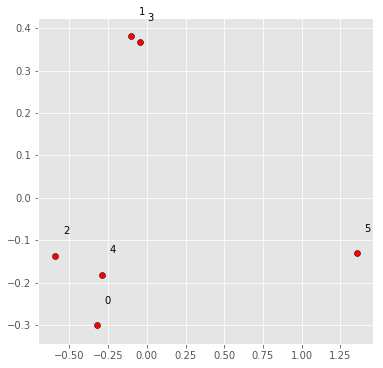

In [10]:

import numpy as np


def impgrafico(nomes, vetors ):
    from sklearn.decomposition import PCA   
    
    #vec = np.transpose(vec)        
    import matplotlib.pyplot as plt


    pca = PCA(n_components=2)
    vectwodim = PCA(n_components=2).fit_transform(vetors)
    
    plt.style.use('ggplot')    
    plt.figure(figsize=(6,6))
    plt.scatter(vectwodim[:,0], vectwodim[:,1], edgecolors='k', c='r')
    
    i =0
    for frase, (x,y) in zip(nomes, vectwodim):
        plt.text(x+0.05, y+0.05, i)
        i =i +1 
        
    i =0   
    for frase in nomes:
        print(i, frase ) 
        i = i +1     
        
        
    plt.show()  
    

    
impgrafico(bookenames, vetors)
    
    
    

##  The reduction process base on user actions generat some insights 
- Self help books are  close to each other
- The Classicos books  are  close to each other too
- however the philosophical books are't so close 


In [ ]:
model.save('/home/desenvolvimento/python/recomender/modelaLS/model')

In [11]:

sc = spark.sparkContext
sqlContext = SQLContext(sc)
#transactiosR =  sqlContext.sql("SELECT  codusu +0 as userCol ,  codobra + 0 as itemCol , 0 as rating from  transacionalObra ")
itensF =  sqlContext.sql("SELECT  * from utensfactor " )

itensF.show(2)

booksa= {}
nresult = itensF.count()
nresult  =16500599
vetors = np.zeros((16500599, 10), dtype=float)

nresult  =200
bookenames = [] 
for  i  in range(nresult):
    idb = itensF.collect()[i]['id']
    npa = np.asarray(itensF.collect()[i]['features'], dtype=np.float32)
    vetors[i] = npa 
    bookenames.append(idb)
    if  i % 100 ==0:
          print(i)              
                         
                            
                         
                         
                         



+---+--------------------+
| id|            features|
+---+--------------------+
|110|[-0.06994427, 0.2...|
|140|[0.92794734, 0.97...|
+---+--------------------+
only showing top 2 rows

0
100


In [13]:
pandas_df = itensF.toPandas()



id                                                        110
features    [-0.06994426995515823, 0.26187601685523987, 0....
Name: 0, dtype: object

In [19]:
pandas_df.to_csv('bookWeight.csv')




In [ ]:

#sed -i 's/\"/\t/g' bookWeight.csv 
#sed -i 's/\["/\t/g' bookWeight.csv 
!sed -i 's/\]"/\t/g' bookWeight.csv 
#sed -i 's/features/codobra,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10/g' bookWeight.csv 


!more bookWeight.csv



